<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [5]:
from numba import njit, prange

np.random.seed(42)
N,M,K = np.random.choice(np.arange(1000),3)
arr2 = np.array(N*[M*[0]+K*[1]]).ravel() - .5
arr1 = np.zeros(len(arr2))
len(arr2), N

(132090, 102)

In [6]:
def crossover(signal, price):
    L = price.shape[0]
    out = np.empty(L, dtype=np.int64)
    out[0] = 0
    for i in range(1,L):
        if signal[i-1] < price[i-1] and signal[i] > price[i]:
            out[i] =1
        else:
            out[i] =0
    return out  

%timeit crossover(arr2,arr1)

42 ms ± 522 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
crossover(arr2,arr1).sum()

102

In [2]:
@njit
def nb_crossover(signal, price):
    L = price.shape[0]
    out = np.empty(L, dtype=np.int64)
    out[0] = 0
    for i in range(1, L):
        if signal[i - 1] < price[i - 1] and signal[i] > price[i]:
            out[i] = 1
        else:
            out[i] = 0
    return out


print(nb_crossover(arr2, arr1).sum())
%timeit -n100 -r1000 nb_crossover(arr2,arr1)

102
203 µs ± 8.95 µs per loop (mean ± std. dev. of 1000 runs, 100 loops each)


In [3]:
@njit(parallel=True)
def nbp_crossover(signal, price):
    L = price.shape[0]
    out = np.empty(L, dtype=np.int32)
    out[0] = 0
    for i in prange(1, L):
        if signal[i - 1] < price[i - 1] and signal[i] > price[i]:
            out[i] = 1
        else:
            out[i] = 0
    return out

print(nbp_crossover(arr2,arr1).sum())
%timeit -n100 -r1000 nbp_crossover(arr2,arr1)

102
The slowest run took 22.15 times longer than the fastest. This could mean that an intermediate result is being cached.
47.1 µs ± 43 µs per loop (mean ± std. dev. of 1000 runs, 100 loops each)


In [4]:
for _ in range(1000):
    N,M,K = np.random.choice(np.arange(1,1000),3)
    arr2 = np.array(N*[M*[0]+K*[1]]).ravel() - .5
    arr1 = np.zeros(len(arr2))
    assert np.allclose(nbp_crossover(arr2,arr1), nb_crossover(arr2,arr1))

In [ ]:
for _ in range(1000):
    N,M,K = np.random.choice(np.arange(1,1000),3)
    arr2 = np.array(N*[M*[0]+K*[1]]).ravel() - .5
    arr1 = np.zeros(len(arr2))
    assert N == nb_crossover(arr2,arr1).sum()

In [ ]:
import time

acc = 0
for _ in range(1000):
    N,M,K = np.random.choice(np.arange(1,1000),3)
    arr2 = np.array(N*[M*[0]+K*[1]]).ravel() - .5
    arr1 = np.zeros(len(arr2))
    start = time.time()
    out = nb_crossover(arr2,arr1)
    finish = time.time()
    acc +=  finish - start
    assert N == out.sum()

print(acc)
# 12.3147554397583

In [ ]:
acc = 0
for _ in range(1000):
    N,M,K = np.random.choice(np.arange(1,1000),3)
    arr2 = np.array(N*[M*[0]+K*[1]]).ravel() - .5
    arr1 = np.zeros(len(arr2))
    start = time.time()
    out = nbp_crossover(arr2,arr1)
    finish = time.time()
    acc +=  finish - start
    assert N == out.sum()

print(acc)
# 7.125715970993042

In [ ]:
# %%timeit -n100 -r100
N,M,K = np.random.choice(np.arange(1,1000),3)
arr2 = np.array(N*[M*[0]+K*[1]]).ravel() - .5
arr1 = np.zeros(len(arr2))
%timeit nb_crossover(arr2,arr1)

In [ ]:
# %%timeit -n100 -r100
N,M,K = np.random.choice(np.arange(1,1000),3)
arr2 = np.array(N*[M*[0]+K*[1]]).ravel() - .5
arr1 = np.zeros(len(arr2))
%timeit nbp_crossover(arr2,arr1)

In [ ]:
from talib import BBANDS
np.random.seed(42)
ret = np.random.randn(1000)/100
price = np.cumprod(1+ ret)
upper, middle, lower = BBANDS(price, 30, 1)
plt.figure(figsize=(15,3))
plt.plot(price, c="black")
plt.plot(upper, c="red")
plt.plot(lower, c="green")
plt.plot(middle, c="blue");

In [1]:
from talib import BBANDS
from numba import njit, prange

np.random.seed(42)
ret = np.random.randn(100000) / 100
price = np.cumprod(1 + ret)

lb = 100
std = 1
upper, middle, lower = BBANDS(price, lb, std)
price = price[lb:]
upper = upper[lb:]
middle = middle[lb:]
lower = lower[lb:]


@njit(parallel=True)
def gen_signal(price, upper, middle, lower):

    L = price.shape[0]
    signal = np.empty(L, dtype=np.int32)

    lower_crossup = 0
    upper_crossdown = 0

    signal[0] = 0
    for i in prange(1, L):

        # lower crossup
        if lower[i - 1] > price[i - 1] and lower[i] < price[i]:
            lower_crossup = 1

        # upper crossdown
        if upper[i - 1] < price[i - 1] and upper[i] > price[i]:
            upper_crossdown = 1

        # enter long
        if lower_crossup:
            signal[i] = 1
            if (middle[i - 1] > price[i - 1] and middle[i] < price[i]) or (
                lower[i - 1] < price[i - 1] and lower[i] > price[i]
            ):
                lower_crossup = 0
                signal[i] = 0

        elif upper_crossdown:
            signal[i] = -1
            if (price[i - 1] > middle[i - 1] and price[i] < middle[i]) or (
                price[i - 1] < upper[i - 1] and price[i] > upper[i]
            ):
                signal[i] = 0
                upper_crossdown = 0
        else:
            signal[i] = 0

    return signal


out=gen_signal(price, upper, middle, lower)
%timeit -n100 -r100 gen_signal(price, upper, middle, lower)

# 88.4 µs ± 10.2 µs per loop (mean ± std. dev. of 100 runs, 100 loops each)

79.3 µs ± 7.12 µs per loop (mean ± std. dev. of 100 runs, 100 loops each)


In [2]:
out = gen_signal(price, upper, middle, lower)
%timeit -n100 -r100 gen_signal(price, upper, middle, lower)

The slowest run took 11.11 times longer than the fastest. This could mean that an intermediate result is being cached.
90.4 µs ± 79.9 µs per loop (mean ± std. dev. of 100 runs, 100 loops each)


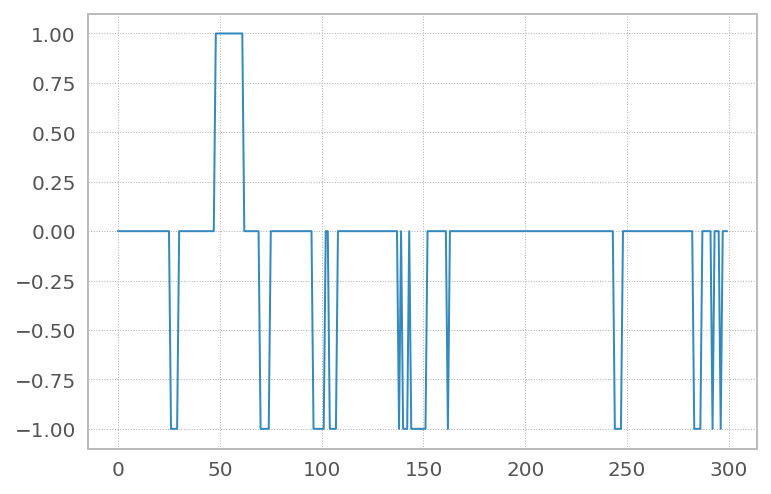

In [3]:
plt.plot(out[:300]);

In [4]:
@njit
def crossup(x, y, i):
    if x[i - 1] < y[i - 1] and x[i] > y[i]:
        return 1
    else:
        return 0


@njit
def crossdown(x, y, i):
    if x[i - 1] > y[i - 1] and x[i] < y[i]:
        return 1
    else:
        return 0


@njit
def gen_signal2(price, upper, middle, lower):

    L = price.shape[0]
    out = np.empty(L, dtype=np.int64)
    out[0] = 0
    i = 1

    while i < L:
                
        if crossup(price, lower, i):
            while not (crossup(price, middle, i) or crossdown(price, lower, i)) and i < L:
                out[i] = 1
                i += 1

        elif crossdown(price, upper, i):
            while not (crossdown(price, middle, i) or crossup(price, upper, i)) and i < L:
                out[i] = -1
                i += 1

        
        out[i] = 0      
        i +=1
          
    return out

out2 = gen_signal2(price, upper, middle, lower)
%timeit -n100 -r100 gen_signal2(price, upper, middle, lower)

350 µs ± 6.42 µs per loop (mean ± std. dev. of 100 runs, 100 loops each)


In [5]:
out2[:35]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1,  0,  0,  0,  0,
        0])

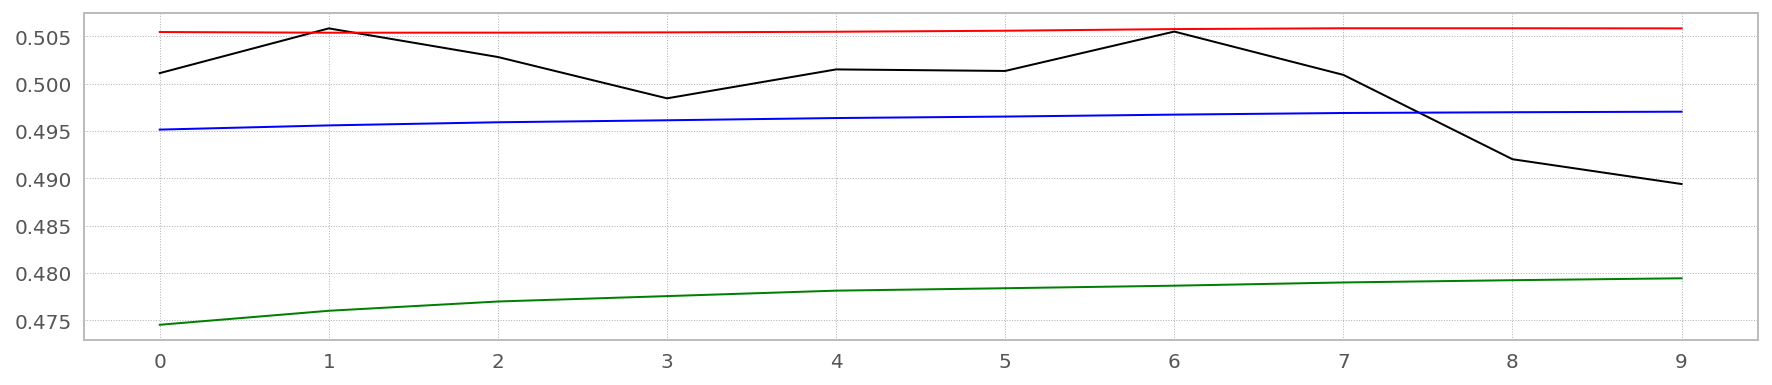

In [5]:
plt.figure(figsize=(15, 3))
plt.plot(price[8320:8330], c="black")
plt.plot(upper[8320:8330], c="red")
plt.plot(lower[8320:8330], c="green")
plt.plot(middle[8320:8330], c="blue")
plt.xticks(range(10));

In [20]:
@njit(parallel=True)
def gen_signal3(price, upper, middle, lower):

    L = price.shape[0]
    out = np.empty(L, dtype=np.int64)
    out[0] = 0
    lower_crossup = 0
    upper_crossdown = 0
    
    for i in prange(1,L):

        if crossup(price, lower, i):
            crossup_lower = 1
            
        if crossdown(price, upper, i):
            crossdown_upper = 1
           
        if crossup_lower:
            out[i] = 1 
            if crossup(price, middle, i) or crossdown(price, lower, i):
                out[i] = 0
                crossup_lower = 0
            
        elif crossdown_upper:
            out[i] = - 1
            if crossdown(price, middle, i) or crossup(price, upper, i):
                out[i] = 0
                crossdown_upper = 0
                
        else:
            out[i] = 0
          
    return out

out3 = gen_signal3(price, upper, middle, lower)
%timeit -n100 -r100 gen_signal3(price, upper, middle, lower)

The slowest run took 4.15 times longer than the fastest. This could mean that an intermediate result is being cached.
90 µs ± 40.7 µs per loop (mean ± std. dev. of 100 runs, 100 loops each)


In [22]:
@njit
def gen_signal4(price, upper, middle, lower):

    L = price.shape[0]
    out = np.empty(L, dtype=np.int64)
    out[0] = 0
    lower_crossup = 0
    upper_crossdown = 0
    
    for i in range(1,L):

        if crossup(price, lower, i):
            crossup_lower = 1
            
        if crossdown(price, upper, i):
            crossdown_upper = 1
           
        if crossup_lower:
            out[i] = 1 
            if crossup(price, middle, i) or crossdown(price, lower, i):
                out[i] = 0
                crossup_lower = 0
            
        elif crossdown_upper:
            out[i] = - 1
            if crossdown(price, middle, i) or crossup(price, upper, i):
                out[i] = 0
                crossdown_upper = 0
                
        else:
            out[i] = 0
          
    return out

out4 = gen_signal4(price, upper, middle, lower)
%timeit -n100 -r100 gen_signal4(price, upper, middle, lower)

442 µs ± 8.27 µs per loop (mean ± std. dev. of 100 runs, 100 loops each)


In [24]:
np.allclose(out2, out3)

False

In [19]:
np.allclose(out, out3)

False

In [23]:
np.allclose(out4, out3)

False

In [25]:
np.allclose(out4, out2)

True

In [9]:
(out != out2).argmax()

8326

In [10]:
out[8320:8330]

array([-1,  0, -1, -1, -1, -1,  0,  0,  0,  0], dtype=int32)

In [11]:
out2[8320:8330]

array([-1,  0, -1, -1, -1, -1, -1, -1,  0,  0])

In [12]:
(price > upper) | (price < middle)

array([ True,  True,  True, ...,  True,  True,  True])

In [13]:
pd.DataFrame(
    {"price": price, "upper": upper, "middle": middle, "crossup": (price > upper)|(price < middle)}
)[8320:8330]

,price,upper,middle,crossup
8320,0.501111,0.505457,0.495143,False
8321,0.505840,0.505383,0.495587,True
8322,0.502814,0.505389,0.495917,False
8323,0.498446,0.505419,0.496127,False
8324,0.501504,0.505486,0.496364,False
8325,0.501341,0.505592,0.496520,False
8326,0.505504,0.505766,0.496726,False
8327,0.500925,0.505852,0.496897,False
8328,0.492012,0.505852,0.496977,True
8329,0.489389,0.505841,0.497036,True
